In [1]:
import os
import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd
from os.path import join

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.utils import to_categorical

import librosa
import kapre
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D

import matplotlib.pyplot as plt
%matplotlib inline 
import scikitplot as skplt

def plot_traincurve(history):
    colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")

    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

def generator(features, labels, batch_size):
    while True:
        batch_features = []
        batch_labels = []
        
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(features),1)
            batch_features.extend(features[index])
            batch_labels.extend(labels[index])
        batch_features = np.array(batch_features)
        batch_labels = np.array(batch_labels)
        yield batch_features, batch_labels    

/home/admiin/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
AUDIO_PATH = '../data/GTZAN_mp3'
classes_temp = os.walk(AUDIO_PATH).next()[1]

list_data = [] 
classes = [] 
load = None
load = True
savename = "offseti2-duration2.npy"

if load:    
    list_data = np.load("list_data-" + savename)
    classes = np.load("classes-" + savename)
else:
    start = time.time()

    for c in classes_temp:
        for root, subdirs, files in os.walk(os.path.join(AUDIO_PATH, c)):
            for file in files:              
                print ".", 
                filepath = os.path.join(root, file)    
                wavedata, samplerate = librosa.load(filepath, sr=None, mono=True, offset=10, duration=10)    
                wavedata = wavedata[np.newaxis, :]
                list_data.append(wavedata)
                classes.append(c)

    np.save("list_data-" + savename, list_data)
    np.save("classes-" + savename, classes)
    print(time.time() - start)

In [3]:
if list_data.shape[1] != 1:
    list_data = list_data.reshape(list_data.shape[0],1,-1)
list_data.shape

(10000, 1, 44100)

In [4]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labelencoder.fit(classes)

n_classes = len(labelencoder.classes_)
print n_classes, "classes:", ", ".join(list(labelencoder.classes_))

classes_num = labelencoder.transform(classes)

10 classes: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock


In [5]:
classes_num_1hot = to_categorical(classes_num)
classes_num_1hot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [6]:
classes_num_1hot.shape

(10000, 10)

In [7]:
data = np.array(list_data)
data.shape

(10000, 1, 44100)

In [8]:
testset_size = 0.25
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes_num)

for train_index, test_index in splits:
    print "TRAIN INDEX:", train_index
    print "TEST INDEX:", test_index
    
    train_set = data[train_index]
    test_set = data[test_index]
    
    train_classes = classes_num[train_index]
    train_classes_1hot = classes_num_1hot[train_index]
    test_classes = classes_num[test_index]

print train_set.shape
print test_set.shape

TRAIN INDEX: [8083 9372 7713 ...  747  459 1636]
TEST INDEX: [5312 8983 1609 ...  742 9797 3974]
(7500, 1, 44100)
(2500, 1, 44100)


In [9]:
cnt = Counter(train_classes)
print "Number of files in each category in TRAIN set:"
for k in sorted(cnt.keys()):
    print k, ":", cnt[k]

Number of files in each category in TRAIN set:
0 : 750
1 : 750
2 : 750
3 : 750
4 : 750
5 : 750
6 : 750
7 : 750
8 : 750
9 : 750


In [10]:
keras.backend.image_dim_ordering()

'tf'

In [11]:
train_set.shape

(7500, 1, 44100)

In [12]:
test_set.shape

(2500, 1, 44100)

In [13]:
input_shape = train_set.shape[1:]  
input_shape

(1, 44100)

In [14]:
np.random.seed(0)
loadModel = None
loadModel = True
modelName = "model1-conv2d"

if loadModel:
    model = keras.models.load_model(modelName + ".h5", custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 
                                                                       'Normalization2D': kapre.utils.Normalization2D})
    history = np.load(modelName + "-history.npy").item()
else:
    model = Sequential()
    model.add(Melspectrogram(n_dft=1024, n_hop=512, input_shape=input_shape, return_decibel_melgram=True, name='melgram'))
    model.add(Normalization2D(str_axis='freq'))

    # Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    # Layer 2
    model.add(Conv2D(32, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Flatten()) 

    model.add(Dense(100, activation='relu')) 
    # model.add(BatchNormalization())
    model.add(Dense(n_classes,activation='softmax'))

    model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['accuracy'])

    history = None
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melgram (Melspectrogram)     (None, 128, 87, 1)        1116288   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 128, 87, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 85, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 20, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19200)             0         
__________

In [15]:
# earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto')
History = model.fit(train_set, train_classes_1hot, validation_split=0.1, batch_size=32, epochs=10)

if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])
        
model.save(modelName + ".h5")
np.save(modelName + "-history.npy", history)

Train on 6750 samples, validate on 750 samples
Epoch 1/10
6750/6750 [==============================] - 41s 6ms/step - loss: 1.8417 - acc: 0.3373 - val_loss: 1.5320 - val_acc: 0.4773
Epoch 2/10
6750/6750 [==============================] - 39s 6ms/step - loss: 1.4734 - acc: 0.4801 - val_loss: 1.4161 - val_acc: 0.5240
Epoch 3/10
6750/6750 [==============================] - 39s 6ms/step - loss: 1.2372 - acc: 0.5695 - val_loss: 1.0944 - val_acc: 0.6080
Epoch 4/10
6750/6750 [==============================] - 39s 6ms/step - loss: 1.0378 - acc: 0.6424 - val_loss: 0.9786 - val_acc: 0.6707
Epoch 5/10
6750/6750 [==============================] - 39s 6ms/step - loss: 0.8892 - acc: 0.6939 - val_loss: 0.9352 - val_acc: 0.6653
Epoch 6/10
6750/6750 [==============================] - 39s 6ms/step - loss: 0.7729 - acc: 0.7338 - val_loss: 0.8876 - val_acc: 0.7000
Epoch 7/10
6750/6750 [==============================] - 39s 6ms/step - loss: 0.6755 - acc: 0.7668 - val_loss: 0.8392 - val_acc: 0.7067
Epoch 8/

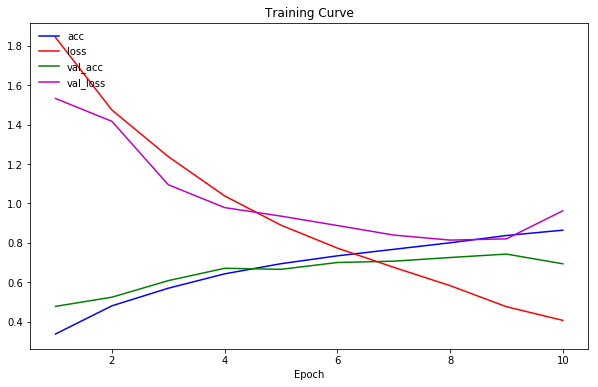

In [16]:
plot_traincurve(history)

In [17]:
test_pred = model.predict_classes(test_set)
test_proba = model.predict_proba(test_set)
test_proba

array([[1.4196568e-04, 9.8678154e-01, 8.9607192e-03, ..., 1.4904381e-03,
        1.9318842e-04, 6.9336139e-04],
       [9.8499000e-01, 5.4972412e-07, 8.1320358e-03, ..., 3.0868799e-07,
        1.7024098e-04, 3.2504587e-04],
       [1.0508359e-06, 1.4454124e-13, 5.4374713e-08, ..., 2.0417529e-06,
        9.7995603e-01, 8.4028197e-06],
       ...,
       [4.5421231e-01, 5.6723952e-06, 3.8780594e-01, ..., 3.0840514e-04,
        1.5855830e-02, 8.0107395e-03],
       [6.1028540e-02, 6.5117657e-02, 5.2040946e-01, ..., 9.9620745e-03,
        2.9315665e-02, 3.4102794e-02],
       [1.0235091e-02, 9.7111482e-08, 2.0755460e-05, ..., 2.5048247e-04,
        5.1571243e-04, 5.0805826e-05]], dtype=float32)

In [18]:
accuracy_score(test_classes, test_pred)

0.686

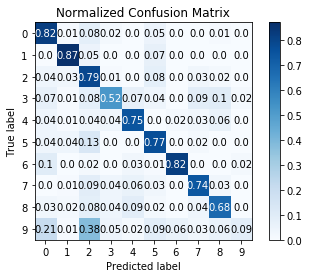

In [19]:
skplt.metrics.plot_confusion_matrix(test_classes, test_pred, normalize=True)

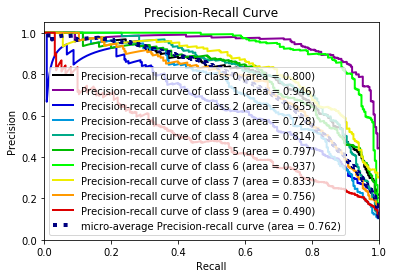

In [20]:
skplt.metrics.plot_precision_recall(test_classes, test_proba)

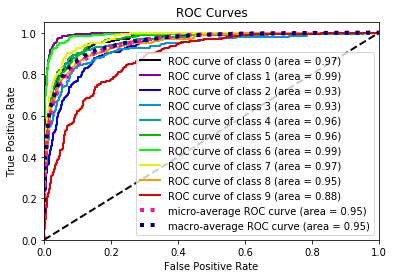

In [21]:
skplt.metrics.plot_roc(test_classes, test_proba)